## Model Serving

### Init ray

In [1]:
import ray
from ray import serve

# Initialize the cluster
ray_head = "ray-head"
ray.init(address=f'ray://{ray_head}:10001')

Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://172.19.0.3:8265


### Start Application

In [2]:
# Start the app
serve.start(detached=False, http_options={'host':"0.0.0.0", 'port':5010})
# serve.start(detached=True, http_options={'host':"0.0.0.0", 'port':5010})

(ServeController pid=804) INFO 2024-01-04 07:55:53,787 controller 804 http_state.py:129 - Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:IGSENt:SERVE_PROXY_ACTOR-bfdd50b9e50beba6a85ce7b2abbd4379833edcc62c34e45ffc4ebe37' on node 'bfdd50b9e50beba6a85ce7b2abbd4379833edcc62c34e45ffc4ebe37' listening on '0.0.0.0:5010'


### Pipeline

In [3]:
import mlflow
import pandas as pd

from fastapi import FastAPI, Query
from pydantic import BaseModel#, Field
from fastapi.responses import HTMLResponse
from fastapi.responses import RedirectResponse


example_values = {
    "specimen_number": 1,
    "eccentricity": 0.86224,
    "aspect_ratio": 2.0735,
    "elongation": 0.52269,
    "solidity": 0.98686,
    "stochastic_convexity": 0.99474,
    "isoperimetric_factor": 0.70529,
    "maximal_indentation_depth": 0.010097,
    "lobedness": 0.018554,
    "average_intensity": 0.041404,
    "average_contrast": 0.12163,
    "smoothness": 0.014579,
    "third_moment": 0.0048689,
    "uniformity": 0.00027608,
    "entropy": 0.9458
}

class Input(BaseModel):
    specimen_number: float = Query(..., gt=0, example=example_values['specimen_number'])
    eccentricity: float = Query(..., gt=0, example=example_values['eccentricity'])
    aspect_ratio: float = Query(..., gt=0, example=example_values['aspect_ratio'])
    elongation: float = Query(..., gt=0, example=example_values['elongation'])
    solidity: float = Query(..., gt=0, example=example_values['solidity'])
    stochastic_convexity: float = Query(..., gt=0, example=example_values['stochastic_convexity'])
    isoperimetric_factor: float = Query(..., gt=0, example=example_values['isoperimetric_factor'])
    maximal_indentation_depth: float = Query(..., gt=0, example=example_values['maximal_indentation_depth'])
    lobedness: float = Query(..., gt=0, example=example_values['lobedness'])
    average_intensity: float = Query(..., gt=0, example=example_values['average_intensity'])
    average_contrast: float = Query(..., gt=0, example=example_values['average_contrast'])
    smoothness: float = Query(..., gt=0, example=example_values['smoothness'])
    third_moment: float = Query(..., gt=0, example=example_values['third_moment'])
    uniformity: float = Query(..., gt=0, example=example_values['uniformity'])
    entropy: float = Query(..., gt=0, example=example_values['entropy'])

    class Config:
        schema_extra = {
            "example": example_values
        }


app = FastAPI(title='Predictor API',
              description='Pipeline online inference')


@serve.deployment()
@serve.ingress(app)
# @serve.deployment()
class LeafDeployment:
    def __init__(self):
        
        # Inicializa los modelos. Los carga desde el MLflow.
        model_name = "extratree"
        model_stage = "Production"
        self.predictor = mlflow.sklearn.load_model(
                                model_uri=f"models:/{model_name}/{model_stage}")

    # Aqui van los metodos que tenga tu pipeline
    def preprocessing(self, df):
        with mlflow.start_run(run_name='preprocessing') as mlrun:
            df_cleaned = df.loc[:, df.columns != 'specimen_number'].copy()
            df_cleaned[df_cleaned.columns] = df_cleaned[df_cleaned.columns].astype(float)
            df_cleaned.to_csv('preprocessed_data.csv', index=False)
            mlflow.log_artifact('preprocessed_data.csv')

            # logging
            mlflow.log_param(key='n_samples', value=len(df_cleaned))
            mlflow.log_param(key='n_features', value=len(df_cleaned.columns))

            return df_cleaned

    @app.get('/', include_in_schema=False)
    async def docs_redirect(self):
        return RedirectResponse(url='/docs')

    @app.post("/predict",
         tags=['Production model'],
         summary="Usar el modelo de produccion")
    def call(self, request: Input):

        data = request.__dict__
        data = pd.json_normalize(data)
        preprocessed = self.preprocessing(data)
        result = self.predictor.predict(preprocessed)

        return result


# LeafDeployment.deploy()
serve.run(LeafDeployment.bind())

(HTTPProxyActor pid=867) INFO:     Started server process [867]
The new client HTTP config differs from the existing one in the following fields: ['host', 'port', 'location']. The new HTTP config is ignored.
(ServeController pid=804) INFO 2024-01-04 07:55:56,080 controller 804 deployment_state.py:1310 - Adding 1 replica to deployment 'LeafDeployment'.


RayServeSyncHandle(deployment='LeafDeployment')

(HTTPProxyActor pid=867) INFO 2024-01-04 07:56:03,050 http_proxy 172.19.0.3 http_proxy.py:361 - GET / 200 7.6ms
(ServeReplica:LeafDeployment pid=948) INFO 2024-01-04 07:56:03,047 LeafDeployment LeafDeployment#SBCVAH replica.py:505 - HANDLE __call__ OK 0.4ms
(HTTPProxyActor pid=867) INFO 2024-01-04 07:56:09,799 http_proxy 172.19.0.3 http_proxy.py:361 - GET / 200 122.0ms
(ServeReplica:LeafDeployment pid=948) INFO 2024-01-04 07:56:09,797 LeafDeployment LeafDeployment#SBCVAH replica.py:505 - HANDLE __call__ OK 117.3ms
(HTTPProxyActor pid=867) INFO 2024-01-04 08:00:34,125 http_proxy 172.19.0.3 http_proxy.py:361 - GET / 307 21.9ms
(HTTPProxyActor pid=867) INFO 2024-01-04 08:00:34,143 http_proxy 172.19.0.3 http_proxy.py:361 - GET / 200 4.6ms
(ServeReplica:LeafDeployment pid=948) INFO 2024-01-04 08:00:34,122 LeafDeployment LeafDeployment#SBCVAH replica.py:505 - HANDLE __call__ OK 17.1ms
(ServeReplica:LeafDeployment pid=948) INFO 2024-01-04 08:00:34,141 LeafDeployment LeafDeployment#SBCVAH repl

Visit http://localhost:5010/docs

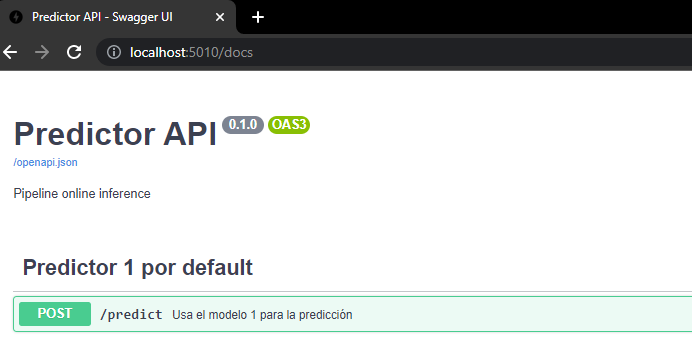

# Cliente

In [8]:
import pandas as pd
import requests

filename = "X_inference.csv"
df = pd.read_csv(filename)
request = df.head(1).to_dict('records')
request

[{'specimen_number': 1,
  'eccentricity': 0.86224,
  'aspect_ratio': 2.0735,
  'elongation': 0.52269,
  'solidity': 0.98686,
  'stochastic_convexity': 0.99474,
  'isoperimetric_factor': 0.70529,
  'maximal_indentation_depth': 0.010097,
  'lobedness': 0.018554,
  'average_intensity': 0.041404,
  'average_contrast': 0.12163,
  'smoothness': 0.014579,
  'third_moment': 0.0048689,
  'uniformity': 0.00027608,
  'entropy': 0.9458}]

In [9]:
response = requests.post("http://ray-head:5010/predict", json=request[0])
result = response.json()[0]
result

32

(HTTPProxyActor pid=1537) INFO 2023-12-13 21:12:00,051 http_proxy 172.18.0.4 http_proxy.py:361 - POST / 200 530.3ms
(ServeReplica:LeafDeployment pid=1619) INFO 2023-12-13 21:12:00,049 LeafDeployment LeafDeployment#shwKgR replica.py:505 - HANDLE __call__ OK 526.1ms
